In [1]:
!pip install torch torchvision transformers opencv-python scikit-learn pillow-avif-plugin
 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 90.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existi

In [2]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()

,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torchvision import transforms
from transformers import BertTokenizer, BertModel
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np

2025-06-09 05:07:58.680078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749445678.895862      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749445678.956302      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['label', 'Unnamed: 5','area'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [5]:
# Remove rows with NaN in 'level' column
df = df.dropna(subset=['level'])
df['level'] = df['level'].astype(int)  # Ensure labels are integers
print("Label distribution after removing NaN:", df['level'].value_counts())

Label distribution after removing NaN: level
1    3165
0    3163
Name: count, dtype: int64


In [6]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [7]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

In [8]:
# Image transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load tokenizer and model for text
tokenizer = BertTokenizer.from_pretrained('csebuetnlp/banglabert')
text_model = BertModel.from_pretrained('csebuetnlp/banglabert')

# Load vision model
vision_model = models.mobilenet_v3_small(pretrained=True)
# vision_model.eval()  # Set to evaluation mode

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.lay

In [9]:
# Move models to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_model.to(device)
vision_model.to(device)

from PIL import UnidentifiedImageError

# Feature extraction functions
def extract_text_features(dataframe, text_column='caption'):
    text_features = []
    text_model.eval()
    with torch.no_grad():
        for text in dataframe[text_column]:
            inputs = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = text_model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # [CLS] token
            text_features.append(cls_embedding[0])
    return np.array(text_features)

from PIL import UnidentifiedImageError

def extract_image_features(dataframe, image_column='id', images_folder='/kaggle/input/mddb-images/Photos_Final'):
    image_features = []
    vision_model.eval()
    with torch.no_grad():
        for image_id in dataframe[image_column]:
            found_image = False
            for ext in ['.jpg', '.png', '.jpeg']:
                image_path = os.path.join(images_folder, f"{image_id}{ext}")
                if os.path.exists(image_path):
                    try:
                        image = Image.open(image_path).convert('RGB')
                        image = image_transforms(image).unsqueeze(0).to(device)
                        features = vision_model(image).cpu().numpy()
                        image_features.append(features[0])
                        found_image = True
                        break  # stop searching extensions if one works
                    except UnidentifiedImageError:
                        print(f"Cannot identify image file: {image_path}")
                        found_image = False
            if not found_image:
                print(f"Image not found or unreadable for ID: {image_id}")
                # Append zero vector or handle missing image as you see fit
                image_features.append(np.zeros(your_feature_size))  # set correct size here
    return np.array(image_features)

# Extract features
train_text_features = extract_text_features(train_data)
valid_text_features = extract_text_features(valid_data)
test_text_features = extract_text_features(test_data)

train_image_features = extract_image_features(train_data)
valid_image_features = extract_image_features(valid_data)
test_image_features = extract_image_features(test_data)

# Concatenate features
train_features = np.concatenate([train_text_features, train_image_features], axis=1)
valid_features = np.concatenate([valid_text_features, valid_image_features], axis=1)
test_features = np.concatenate([test_text_features, test_image_features], axis=1)

# Labels
train_labels = train_data['level'].values
valid_labels = valid_data['level'].values
test_labels = test_data['level'].values

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Model with regularization and tweaks ---
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,   # lower learning rate
    max_depth=3,          # shallower trees
    reg_lambda=1,         # L2 regularization (default is 1)
    reg_alpha=0.1,        # L1 regularization
    subsample=0.8,        # row sampling
    colsample_bytree=0.8, # feature sampling
    random_state=42,
    n_jobs=-1
)

# --- Train with early stopping ---
xgb_model.fit(
    train_features, train_labels,
    eval_set=[(valid_features, valid_labels)],
    eval_metric='logloss',
    early_stopping_rounds=10,  # stop if no improvement in 10 rounds
    verbose=True
)

# --- Evaluate ---
# Training
train_preds_xgb = xgb_model.predict(train_features)
train_acc_xgb = accuracy_score(train_labels, train_preds_xgb)
print("XGBoost Training Accuracy:", train_acc_xgb)

# Validation
valid_preds_xgb = xgb_model.predict(valid_features)
valid_acc_xgb = accuracy_score(valid_labels, valid_preds_xgb)
print("XGBoost Validation Accuracy:", valid_acc_xgb)

print("Gap (train - valid):", train_acc_xgb - valid_acc_xgb)

# Classification reports
print("\nValidation Classification Report:\n", classification_report(valid_labels, valid_preds_xgb, target_names=['Non Informative', 'Informative']))

# Test set
test_preds_xgb = xgb_model.predict(test_features)
test_acc_xgb = accuracy_score(test_labels, test_preds_xgb)
print("\nTest Accuracy:", test_acc_xgb)
print("Test Classification Report:\n", classification_report(test_labels, test_preds_xgb, target_names=['Non Informative', 'Informative']))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds_xgb, labels=[0, 1])
print("Confusion Matrix:\n", cm)


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.66580
[1]	validation_0-logloss:0.64100
[2]	validation_0-logloss:0.61881
[3]	validation_0-logloss:0.59771
[4]	validation_0-logloss:0.57816
[5]	validation_0-logloss:0.56177
[6]	validation_0-logloss:0.54484
[7]	validation_0-logloss:0.52922
[8]	validation_0-logloss:0.51423
[9]	validation_0-logloss:0.50086
[10]	validation_0-logloss:0.48838
[11]	validation_0-logloss:0.47638
[12]	validation_0-logloss:0.46470
[13]	validation_0-logloss:0.45392
[14]	validation_0-logloss:0.44400
[15]	validation_0-logloss:0.43384
[16]	validation_0-logloss:0.42495
[17]	validation_0-logloss:0.41731
[18]	validation_0-logloss:0.40933
[19]	validation_0-logloss:0.40159
[20]	validation_0-logloss:0.39481
[21]	validation_0-logloss:0.38760
[22]	validation_0-logloss:0.38169
[23]	validation_0-logloss:0.37522
[24]	validation_0-logloss:0.36888
[25]	validation_0-logloss:0.36282
[26]	validation_0-logloss:0.35688
[27]	validation_0-logloss:0.35126
[28]	validation_0-logloss:0.34603
[29]	validation_0-loglos

In [11]:
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Initialize and train XGBoost
# xgb_model = XGBClassifier(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=5,
#     random_state=42,
#     n_jobs=-1
# )
# xgb_model.fit(train_features, train_labels, eval_set=[(valid_features, valid_labels)], eval_metric='logloss', verbose=False)

# # Evaluate on validation set
# valid_preds = xgb_model.predict(valid_features)
# print("Validation Accuracy:", accuracy_score(valid_labels, valid_preds))
# print("Validation Classification Report:\n", classification_report(valid_labels, valid_preds, target_names=['Non Informative', 'Informative']))

# # Evaluate on test set
# test_preds = xgb_model.predict(test_features)
# print("Test Accuracy:", accuracy_score(test_labels, test_preds))
# print("Test Classification Report:\n", classification_report(test_labels, test_preds, target_names=['Non Informative', 'Informative']))

SVM Validation Accuracy: 0.9541864139020537
Validation Classification Report:
                  precision    recall  f1-score   support

Non Informative       0.95      0.95      0.95       634
    Informative       0.95      0.95      0.95       632

       accuracy                           0.95      1266
      macro avg       0.95      0.95      0.95      1266
   weighted avg       0.95      0.95      0.95      1266


SVM Test Accuracy: 0.9391785150078988
Test Classification Report:
                  precision    recall  f1-score   support

Non Informative       0.96      0.92      0.94       654
    Informative       0.92      0.96      0.94       612

       accuracy                           0.94      1266
      macro avg       0.94      0.94      0.94      1266
   weighted avg       0.94      0.94      0.94      1266



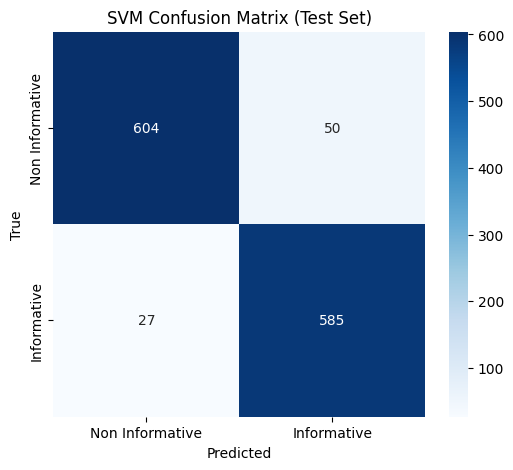

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train SVM model
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(train_features, train_labels)

# Validation set predictions
valid_preds = svm_model.predict(valid_features)
valid_acc = accuracy_score(valid_labels, valid_preds)
print("SVM Validation Accuracy:", valid_acc)
print("Validation Classification Report:\n", classification_report(valid_labels, valid_preds, target_names=['Non Informative', 'Informative']))

# Test set predictions
test_preds = svm_model.predict(test_features)
test_acc = accuracy_score(test_labels, test_preds)
print("\nSVM Test Accuracy:", test_acc)
print("Test Classification Report:\n", classification_report(test_labels, test_preds, target_names=['Non Informative', 'Informative']))

# Optional: Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Informative', 'Informative'], yticklabels=['Non Informative', 'Informative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix (Test Set)')
plt.show()


RF Validation Accuracy: 0.8941548183254344
Validation Classification Report:
                  precision    recall  f1-score   support

Non Informative       0.89      0.90      0.89       634
    Informative       0.90      0.89      0.89       632

       accuracy                           0.89      1266
      macro avg       0.89      0.89      0.89      1266
   weighted avg       0.89      0.89      0.89      1266


RF Test Accuracy: 0.906003159557662
Test Classification Report:
                  precision    recall  f1-score   support

Non Informative       0.92      0.90      0.91       654
    Informative       0.89      0.92      0.90       612

       accuracy                           0.91      1266
      macro avg       0.91      0.91      0.91      1266
   weighted avg       0.91      0.91      0.91      1266



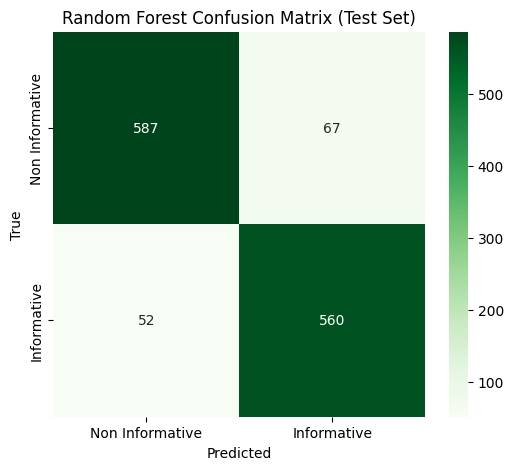

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf_model.fit(train_features, train_labels)

# Validation predictions
valid_preds = rf_model.predict(valid_features)
valid_acc = accuracy_score(valid_labels, valid_preds)
print("RF Validation Accuracy:", valid_acc)
print("Validation Classification Report:\n", classification_report(valid_labels, valid_preds, target_names=['Non Informative', 'Informative']))

# Test predictions
test_preds = rf_model.predict(test_features)
test_acc = accuracy_score(test_labels, test_preds)
print("\nRF Test Accuracy:", test_acc)
print("Test Classification Report:\n", classification_report(test_labels, test_preds, target_names=['Non Informative', 'Informative']))

# Optional: Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non Informative', 'Informative'], yticklabels=['Non Informative', 'Informative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Validation Accuracy: 0.9368088467614534
Validation Classification Report:
                  precision    recall  f1-score   support

Non Informative       0.92      0.95      0.94       634
    Informative       0.95      0.92      0.94       632

       accuracy                           0.94      1266
      macro avg       0.94      0.94      0.94      1266
   weighted avg       0.94      0.94      0.94      1266


LR Test Accuracy: 0.9273301737756714
Test Classification Report:
                  precision    recall  f1-score   support

Non Informative       0.91      0.95      0.93       654
    Informative       0.94      0.91      0.92       612

       accuracy                           0.93      1266
      macro avg       0.93      0.93      0.93      1266
   weighted avg       0.93      0.93      0.93      1266



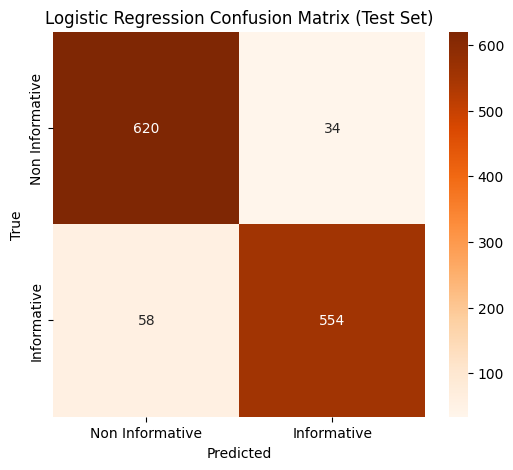

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(train_features, train_labels)

# Validation predictions
valid_preds = lr_model.predict(valid_features)
valid_acc = accuracy_score(valid_labels, valid_preds)
print("LR Validation Accuracy:", valid_acc)
print("Validation Classification Report:\n", classification_report(valid_labels, valid_preds, target_names=['Non Informative', 'Informative']))

# Test predictions
test_preds = lr_model.predict(test_features)
test_acc = accuracy_score(test_labels, test_preds)
print("\nLR Test Accuracy:", test_acc)
print("Test Classification Report:\n", classification_report(test_labels, test_preds, target_names=['Non Informative', 'Informative']))

# Optional: Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Non Informative', 'Informative'], yticklabels=['Non Informative', 'Informative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix (Test Set)')
plt.show()


[10]	valid_0's binary_logloss: 0.363661
[20]	valid_0's binary_logloss: 0.256932
[30]	valid_0's binary_logloss: 0.208013
[40]	valid_0's binary_logloss: 0.181767
[50]	valid_0's binary_logloss: 0.163071
[60]	valid_0's binary_logloss: 0.152541
[70]	valid_0's binary_logloss: 0.143838
[80]	valid_0's binary_logloss: 0.138871
[90]	valid_0's binary_logloss: 0.136327
[100]	valid_0's binary_logloss: 0.133651
LightGBM Validation Accuracy: 0.9439178515007899
Validation Classification Report:
                  precision    recall  f1-score   support

Non Informative       0.94      0.95      0.94       634
    Informative       0.95      0.94      0.94       632

       accuracy                           0.94      1266
      macro avg       0.94      0.94      0.94      1266
   weighted avg       0.94      0.94      0.94      1266


LightGBM Test Accuracy: 0.9486571879936809
Test Classification Report:
                  precision    recall  f1-score   support

Non Informative       0.96      0.94   

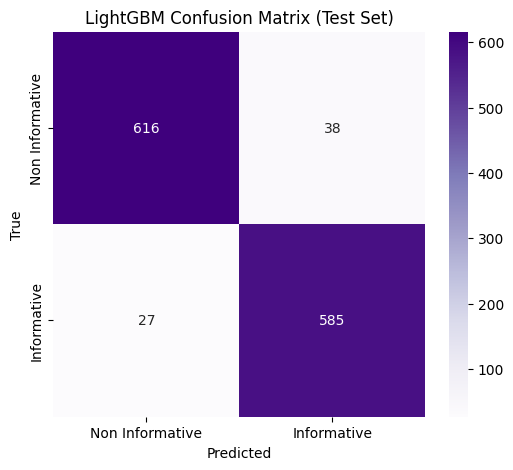

In [18]:
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize LightGBM classifier with verbosity suppressed
lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=-1  # disable internal LightGBM logs
)

# Train model with evaluation set and logging callback
lgbm_model.fit(
    train_features,
    train_labels,
    eval_set=[(valid_features, valid_labels)],
    eval_metric='logloss',
    callbacks=[log_evaluation(period=10)]  # print eval metric every 10 iterations
)

# Validation predictions and metrics
valid_preds = lgbm_model.predict(valid_features)
valid_acc = accuracy_score(valid_labels, valid_preds)
print("LightGBM Validation Accuracy:", valid_acc)
print("Validation Classification Report:\n", classification_report(valid_labels, valid_preds, target_names=['Non Informative', 'Informative']))

# Test predictions and metrics
test_preds = lgbm_model.predict(test_features)
test_acc = accuracy_score(test_labels, test_preds)
print("\nLightGBM Test Accuracy:", test_acc)
print("Test Classification Report:\n", classification_report(test_labels, test_preds, target_names=['Non Informative', 'Informative']))

# Plot confusion matrix on test set
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=['Non Informative', 'Informative'],
    yticklabels=['Non Informative', 'Informative']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LightGBM Confusion Matrix (Test Set)')
plt.show()


In [ ]:
# # (Add feature extraction code from above)

# # Train XGBoost
# xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
# xgb_model.fit(train_features, train_labels, eval_set=[(valid_features, valid_labels)], eval_metric='logloss', verbose=False)

# # Evaluate
# valid_preds = xgb_model.predict(valid_features)
# print("Validation Accuracy:", accuracy_score(valid_labels, valid_preds))
# print("Validation Classification Report:\n", classification_report(valid_labels, valid_preds, target_names=['Non Informative', 'Informative']))

# test_preds = xgb_model.predict(test_features)
# print("Test Accuracy:", accuracy_score(test_labels, test_preds))
# print("Test Classification Report:\n", classification_report(test_labels, test_preds, target_names=['Non Informative', 'Informative']))

# # Confusion matrix
# cm = confusion_matrix(test_labels, test_preds, labels=[0, 1])
# print("Confusion Matrix:\n", cm)

# # (Add Chart.js code from above)

# cm = confusion_matrix(test_labels, test_preds, labels=[0, 1])

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("BanglaBERT Parameters:", count_parameters(text_model))
print("MobileNetV3-Small Parameters:", count_parameters(vision_model))
print("XGBoost Trees:", xgb_model.n_estimators)
print("XGBoost Total Nodes:", sum(len(tree.split('\n')) for tree in xgb_model.get_booster().get_dump()))

BanglaBERT Parameters: 110617344
MobileNetV3-Small Parameters: 2542856
XGBoost Trees: 100
XGBoost Total Nodes: 1596


In [20]:
# Logistic Regression total parameters
total_params_lr = lr_model.coef_.size + lr_model.intercept_.size
print("Total Logistic Regression Parameters:", total_params_lr)

# SVM total parameters (if linear kernel)
if svm_model.kernel == 'linear':
    total_params_svm = svm_model.coef_.size + svm_model.intercept_.size
    print("Total SVM Parameters:", total_params_svm)
else:
    print("Non-linear SVM kernel. No explicit parameter count.")

# LightGBM total “parameters” as total nodes
total_nodes_lgb = sum(tree['num_leaves'] for tree in lgbm_model.booster_.dump_model()['tree_info'])
print("Total LightGBM Nodes (like parameters):", total_nodes_lgb)


Total Logistic Regression Parameters: 1769
Non-linear SVM kernel. No explicit parameter count.
Total LightGBM Nodes (like parameters): 2561


In [21]:
from sklearn.model_selection import cross_val_score
import numpy as np

xgb_cv_scores = cross_val_score(xgb_model, train_features, train_labels, cv=5, scoring='accuracy', n_jobs=-1)
print("XGBoost 5-Fold CV Accuracy:", xgb_cv_scores)
print("Mean CV Accuracy:", np.mean(xgb_cv_scores))


XGBoost 5-Fold CV Accuracy: [0.93684211 0.91172596 0.93017128 0.91831357 0.90909091]
Mean CV Accuracy: 0.9212287636086263


In [22]:
lgbm_cv_scores = cross_val_score(lgbm_model, train_features, train_labels, cv=5, scoring='accuracy', n_jobs=-1)
print("LightGBM 5-Fold CV Accuracy:", lgbm_cv_scores)
print("Mean CV Accuracy:", np.mean(lgbm_cv_scores))


LightGBM 5-Fold CV Accuracy: [0.95263158 0.93017128 0.93675889 0.93280632 0.92226614]
Mean CV Accuracy: 0.9349268427986963


In [ ]:
# Training Accuracy
train_preds_xgb = xgb_model.predict(train_features)
train_acc_xgb = accuracy_score(train_labels, train_preds_xgb)
print("XGBoost Training Accuracy:", train_acc_xgb)

# Validation Accuracy
valid_preds_xgb = xgb_model.predict(valid_features)
valid_acc_xgb = accuracy_score(valid_labels, valid_preds_xgb)
print("XGBoost Validation Accuracy:", valid_acc_xgb)

print("Gap (train - valid):", train_acc_xgb - valid_acc_xgb)
